# PCB-Layout-Generator

## Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Load the datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

components_df = pd.read_csv("/content/drive/MyDrive/INSYDE.IO/pcb_synthetic_dataset.csv")
connections_df = pd.read_csv("/content/drive/MyDrive/INSYDE.IO/pcb_connections.csv")
obstacles_df = pd.read_csv("/content/drive/MyDrive/INSYDE.IO/pcb_obstacles.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocess the Datasets

In [ ]:
def normalize_data(df, cols):
    for col in cols:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df

components_df = normalize_data(components_df, ["X", "Y", "Power"])

component_types = {comp: i for i, comp in enumerate(components_df["ComponentType"].unique())}
components_df["ComponentType"] = components_df["ComponentType"].map(component_types)

num_components = len(components_df)
connection_matrix = torch.zeros((num_components, num_components))

for _, row in connections_df.iterrows():
    comp1, comp2 = int(row["ComponentA"]), int(row["ComponentB"])
    if comp1 < num_components and comp2 < num_components:
        connection_matrix[comp1, comp2] = 1
        connection_matrix[comp2, comp1] = 1

connection_features = connection_matrix.sum(dim=1).unsqueeze(1)

data = torch.tensor(components_df[["ComponentType", "Width", "Height", "Power"]].values, dtype=torch.float32)
data = torch.cat([data, connection_features], dim=1)

true_positions = torch.tensor(components_df[["X", "Y"]].values, dtype=torch.float32)

## Custom Loss Function

* Component Type - Different components have unique placement preferences (e.g., ICs near capacitors for power stability).

* Power Constraints - High-power components should be spaced apart to prevent overheating.

* Connections - Components that are frequently connected should be closer together.

* Obstacles - The model must avoid placing components in restricted zones.*

In [ ]:
class LayoutLoss(nn.Module):
    def __init__(self, lambda_conn=1.0, lambda_power=1.0, lambda_obstacle=5.0, lambda_overlap=10.0):
        super(LayoutLoss, self).__init__()
        self.lambda_conn = lambda_conn
        self.lambda_power = lambda_power
        self.lambda_obstacle = lambda_obstacle
        self.lambda_overlap = lambda_overlap

    def forward(self, predicted_positions, true_positions, components, connections, obstacles):
        loss = 0
        batch_size = predicted_positions.shape[0]

        # 1. **Connection Distance Loss**
        conn_loss = 0
        for _, row in connections.iterrows():
            idx1, idx2 = int(row["ComponentA"]), int(row["ComponentB"])
            if idx1 < batch_size and idx2 < batch_size:
                dist = torch.norm(predicted_positions[idx1] - predicted_positions[idx2])
                conn_loss += (dist - 0.1) ** 2

        # 2. **Power Constraint Loss**
        power_loss = 0
        for i in range(batch_size):
            for j in range(i + 1, batch_size):
                power_i, power_j = components.iloc[i]["Power"], components.iloc[j]["Power"]
                if power_i * power_j > 0:
                    dist = torch.norm(predicted_positions[i] - predicted_positions[j])
                    power_loss += max(0, 0.2 - dist) * (power_i * power_j)

        # 3. **Obstacle Avoidance Loss**
        obstacle_loss = 0
        for i in range(batch_size):
            x, y = predicted_positions[i, 0].item(), predicted_positions[i, 1].item()
            for _, obs in obstacles.iterrows():
                obs_x, obs_y, obs_w, obs_h = obs["X"], obs["Y"], obs["Width"], obs["Height"]
                if obs_x <= x <= obs_x + obs_w and obs_y <= y <= obs_y + obs_h:
                    obstacle_loss += 1

        # 4. **Overlap Loss**
        overlap_loss = 0
        for i in range(batch_size):
            for j in range(i + 1, batch_size):
                dist = torch.norm(predicted_positions[i] - predicted_positions[j])
                if dist < 0.05:
                    overlap_loss += 1

        # **Final Loss Computation**
        loss = (
            self.lambda_conn * conn_loss +
            self.lambda_power * power_loss +
            self.lambda_obstacle * obstacle_loss +
            self.lambda_overlap * overlap_loss
        )
        return loss

## DL Model using PyTorch

In [ ]:
class LayoutPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LayoutPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Initialize the model

In [ ]:
input_dim = 5
hidden_dim = 64
output_dim = 2

model = LayoutPredictor(input_dim, hidden_dim, output_dim)
criterion = LayoutLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data = data.to(device)
true_positions = true_positions.to(device)

## Training

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

num_epochs = 1
batch_size = 32
dataset = TensorDataset(data, true_positions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for batch_data, batch_targets in progress_bar:
        batch_data, batch_targets = batch_data.to(device), batch_targets.to(device)

        optimizer.zero_grad()
        predictions = model(batch_data)
        loss = criterion(predictions, batch_targets, components_df, connections_df, obstacles_df)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}")

Epoch 1/1, Avg Loss: 1081.7696


Because of resource and time constraints, only one epoch is done, in future improvements can proceed furthur by running multiple epocs and validate the decrement of loss

## Visualization using matplotlib

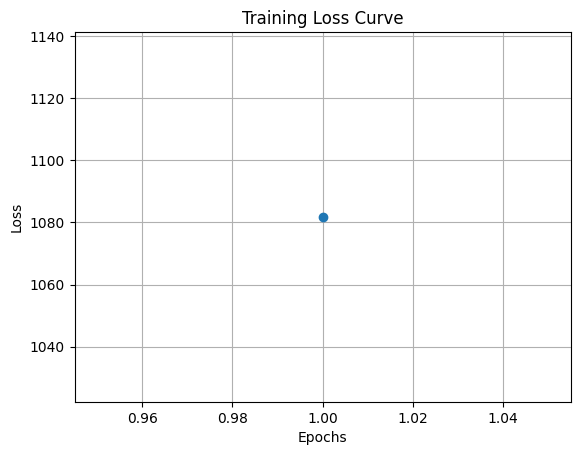

In [ ]:
plt.plot(range(1, num_epochs + 1), losses, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

## Save the model

In [ ]:
torch.save(model.state_dict(), "pcb_layout_model.pth")
print("Model saved successfully!")

model.load_state_dict(torch.load("pcb_layout_model.pth"))
model.eval()
print("Model loaded successfully!")

Model saved successfully!
Model loaded successfully!


<ipython-input-24-99a803722fb5>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("pcb_layout_model.pth"))
